
Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.4 от 30.11.2024

Хабибуллин Ринат 2024 г.

---

# Формула Дюпюи и построение простых решений с python
Решение для задачи стационарного притока к вертикальной скважине в однородном изотропном пласте круговой формы с постоянным давлением на границе имеет вид

\begin{equation}
Q=\dfrac{kh}{18.42\mu B} \dfrac{P_{res}-P_{wf}}{\ln \dfrac{r_e}{r_w} + S}
\end{equation}

где 

* $Q$ - дебит скважины на поверхности, приведенный к нормальным условиям, ст. м$^3$/сут

* $\mu$ - вязкость нефти в пласте, сП

* $B$ - объемный коэффициент нефти, м$^3$/м$^3$

* $P_{res}$ - пластовое давление или давление на контуре с радиусом $r_e$, атма

* $P_{wf}$ - давление забойное, атма

* $k$ - проницаемость, мД

* $h$ - мощность пласта, м

* $r_e$ - внешний контур дренирования скважины, м

* $r_w$ - радиус скважины, м

* $S$ - скин-фактор скважины, м

Это решение известно как [закон Дарси](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%94%D0%B0%D1%80%D1%81%D0%B8) или [формула Дюпюи](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C_(%D0%BD%D0%B5%D1%84%D1%82%D0%B5%D0%B4%D0%BE%D0%B1%D1%8B%D1%87%D0%B0)).

Выражение можно переписать в виде

$$
P_{r} = P_{res} - 18.42\dfrac{ Q\mu B }{kh} \left[ \ln\dfrac{r_e}{r} +S \right]
$$

который удобен для расчета распределения давления в пласте $P_r$ на произвольном расстоянии от скважины $r$.
Здесь задано граничное значение давления $p_e$ на контуре $r_e$. Расчет позволит найти любое значение внутри контура, в том числе и забойное давление $P_{wf}$ на $r=r_w$

Также выражение можно переписать 

$$
P_{r} = P_{wf} + 18.42 \dfrac{ Q\mu B }{kh} [ \ln \dfrac{r}{ r_w } +S ]
$$

где по известному дебиту и забойному давлению можно найти давление в пласте. При известном пластовом давлении можно оценить радиус контура на котором оно достигается.

In [1]:
# Импортируем библиотеки для расчетов. 
import numpy as np
import matplotlib.pyplot as plt
import scipy

Для удобства дальнейшего изложения и использования расчетных функций при создании функций и переменных на языке python
названия формируются по следующим принципам:

* сначала указывается, что расчитывается в функции, в данном случае - давление $p$

* потом указываются пояснения - в данном случае p_ss - steady state pressure

* в конце указывается размерность в которой ожидается получаение ответа - в данном случае atma - абсолютные атмосферы.

In [2]:
# Определим функции для расчета стационарного решения
def dp_ss_atm(q_liq_sm3day = 50,
               mu_cP = 1,
               b_m3m3 = 1.2,
               kh_mDm = 40,
               r_e_m = 240,
               r_m = 0.1):
  """
  Функция расчета перепада давления в произвольной точке пласта 
  на расстоянии r_m от центра скважины для стационарного решения
 
  - q_liq_sm3day - дебит жидкости на поверхности в стандартных условиях
  - mu_cP - вязкость нефти (в пластовых условиях)
  - B_m3m3 - объемный коэффициент нефти 
  - kh_mDm - kh пласта
  - r_e_m - радиус контрура питания, м  
  - r_m - расстояние на котором проводится расчет, м
  """
  return 18.42 * q_liq_sm3day * mu_cP * b_m3m3/ kh_mDm * np.log(r_e_m/r_m)

def p_ss_atma(p_res_atma = 250,
              q_liq_sm3day = 50,
              mu_cP = 1,
              b_m3m3 = 1.2,
              k_mD = 40,
              h_m = 10,
              r_e_m = 240,
              r_m = 0.1):
  """
  функция расчета давления в произвольной точке пласта 
  на расстоянии r_m от центра скважины для стационарного решения 

  - p_res_atma - пластовое давление, давление на контуре питания
  - q_liq_sm3day - дебит жидкости на поверхности в стандартных условиях
  - mu_cP - вязкость нефти (в пластовых условиях)
  - B_m3m3 - объемный коэффициент нефти 
  - k_mD - проницаемость пласта
  - h_m - мощность пласта, м
  - r_e_m - радиус контрура питания, м  
  - r_m - расстояние на котором проводится расчет, м
  """
  return p_res_atma - dp_ss_atm(q_liq_sm3day = q_liq_sm3day,
                                mu_cP = mu_cP,
                                b_m3m3 = b_m3m3,
                                kh_mDm = k_mD * h_m,
                                r_e_m = r_e_m,
                                r_m = r_m)

## Построение графика с использованием `matplotlib` 

Самый простой пример построения графиков в python - использование библиотеки matplotlib.

Построим график распределения давления в пласте - воронку депресси ориентируясь на выражение (10.2).

Для формирования графика требуется создать два массива значений - x и y и отобразить их. Для формирования массива используются методы библиотеки numpy.

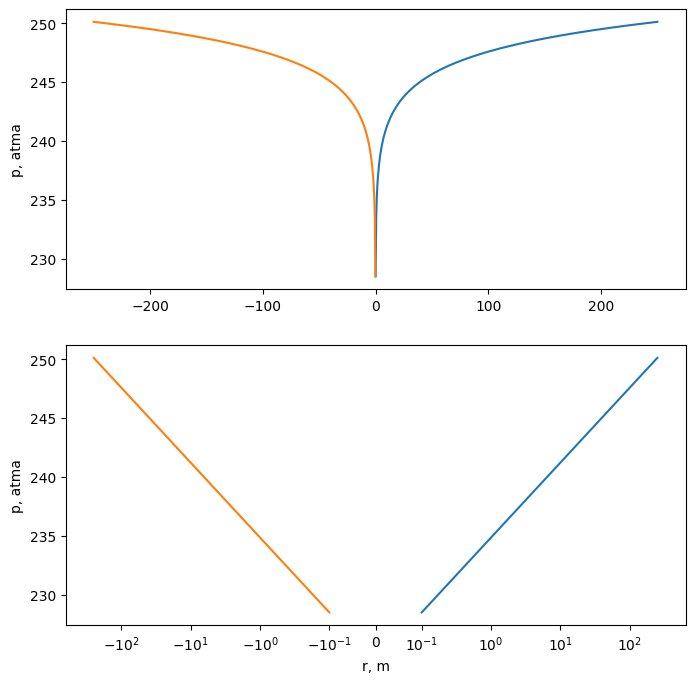

In [3]:
"""
Построим график распределения давления в пласте
"""
# формируем массив расстояний для которых будем проводить расчет
r_arr = np.linspace(0.1, 250, 500) 

# рассчитываем массив давлений на соответствующих расстояниях
# для расчета используется векторный расчет numpy - нет необходимости делать цикл в явном виде
# для примера показана передача всех аргументов созданной функции
p_arr = p_ss_atma(p_res_atma=250,
                  q_liq_sm3day=50,
                  mu_cP=1,
                  b_m3m3=1.2,
                  k_mD=40,
                  h_m=10,
                  r_e_m=240,
                  r_m=r_arr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

# рисуем график в обычных координатах
ax1.plot(r_arr, p_arr)   # команда отрисовки графика по заданным массивам
ax1.plot(-r_arr, p_arr)
# настраиваем график
#ax1.set_title('Воронка депрессии - распределение давления в пласте')
#ax1.set_xlabel('r, m')
ax1.set_ylabel('p, atma')

# рисуем график в логарифмических координатах
ax2.plot(r_arr, p_arr)   # команда отрисовки графика по заданным массивам
ax2.plot(-r_arr, p_arr) 
# настраиваем график
#ax2.set_title('Воронка депрессии - распределение давления в пласте')
ax2.set_xlabel('r, m')
ax2.set_ylabel('p, atma')
ax2.set_xscale('symlog', linthresh=0.1, linscale=0.6)
plt.show()

Оценим среднее давление в области дренирования 

$$P = \frac{1}{\pi (r_e^2-r_w^2)} \int\limits_{r_w}^{r_e} 2 \pi r p(r) dr $$

Среднее давление в области дренирования p_average_atma = 248.61850373561902


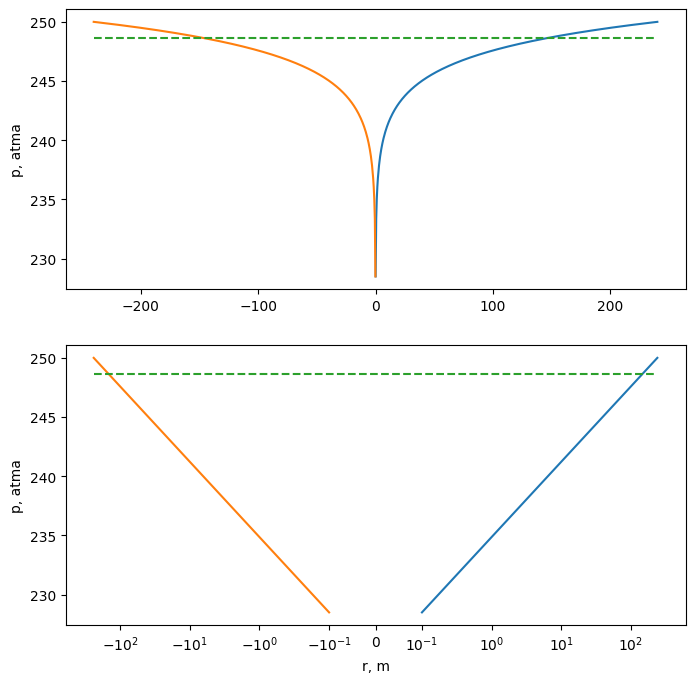

In [4]:
# оценим среднее давление в области дренирования
r_external_m = 240
r_well_m = 0.1
p_average_atma = scipy.integrate.quad(lambda r:p_ss_atma(p_res_atma=250,
                                                         q_liq_sm3day=50,
                                                         mu_cP=1,
                                                         b_m3m3=1.2,
                                                         k_mD=40,
                                                         h_m=10,
                                                         r_e_m=r_external_m,
                                                         r_m=r) * 2  * r, 
                                      r_well_m, 
                                      r_external_m)[0]   / (r_external_m**2 - r_well_m**2) 
print(f"Среднее давление в области дренирования p_average_atma = {p_average_atma}")

r_arr = np.linspace(r_well_m, r_external_m, 500)
r_full = np.linspace(-r_external_m, r_external_m, 10) 

# рассчитываем массив давлений на соответствующих расстояниях
# для расчета используется векторный расчет numpy - нет необходимости делать цикл в явном виде
# для примера показана передача всех аргументов созданной функции
p_arr = p_ss_atma(p_res_atma=250,
                  q_liq_sm3day=50,
                  mu_cP=1,
                  b_m3m3=1.2,
                  k_mD=40,
                  h_m=10,
                  r_e_m=r_external_m,
                  r_m=r_arr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

# рисуем график в обычных координатах
ax1.plot(r_arr, p_arr)   # команда отрисовки графика по заданным массивам
ax1.plot(-r_arr, p_arr)
ax1.plot(r_full, np.full_like(r_full, p_average_atma), linestyle='dashed')
# настраиваем график
#ax1.set_title('Воронка депрессии - распределение давления в пласте')
#ax1.set_xlabel('r, m')
ax1.set_ylabel('p, atma')

# рисуем график в логарифмических координатах
ax2.plot(r_arr, p_arr)   # команда отрисовки графика по заданным массивам
ax2.plot(-r_arr, p_arr) 
ax2.plot(r_full, np.full_like(r_full, p_average_atma), linestyle='dashed')
# настраиваем график
#ax2.set_title('Воронка депрессии - распределение давления в пласте')
ax2.set_xlabel('r, m')
ax2.set_ylabel('p, atma')
ax2.set_xscale('symlog', linthresh=0.1, linscale=0.6)
plt.show()

График имеет вид логарифмической зависимости, на графике в полулогарифмических координатах он будет выглядеть как прямая линия.

# Задания для самостоятельной работы 

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте график распределения давления в пласте для композитного пласта. В композитном пласте на расстоянии $r<r_1$ проницаемость равна $k=k_1$, а для $r>=r_1$, $k=k_2$. 
2. Постройте двумерную тепловую карту распределения давления в пласте для моделей однородного пласта и композитного пласта. 
3. Рассчитайте среднюю величину давления в круговой области дренирования для однородного пласта. Насколько среднее давление в круговой области дренирования будет отличаться от давления на контуре. Чему будет равен коэффициент $S$ в выражении  $Q=\dfrac{kh}{18.41\mu B} \dfrac{P_{res}-P_{wf}}{ln(\dfrac{r_e}{r_w})+S}$ при использовании вместо давления на контуре среднего давления? Постройте график, на котором будет отображаться распределение давления в зоне дренирования и величина среднего давления (в виде линии).
4. Для примера с несколькими скважинами имитирующими трещину ГРП рассчитайте дебиты скважин таким образом, чтобы забойное давление на всех скважинах было одинаковым. Постройте графики распределения давления в пласте. Постройте график дебитов вдоль "скважины".